In [14]:
# importlib.reload(concept_generalization)
from concept_generalization import *

In [2]:
center_list = [[0,0,0], [0,0,1], [0,1,0], [1,0,0], [0,1,1], [1,0,1], [1,1,0], [1,1,1]]
var_list = [ [[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.01] ]]*8
test_centers = [[0,0,0], [0,0,1], [0,1,0], [1,0,0], [0,1,1], [1,0,1], [1,1,0], [1,1,1]]
test_vars = [ [[0.001, 0, 0], [0, 0.001, 0], [0, 0, 0.001] ]]*8
# hidd_list = [128, 256, 512, 1024, 2048]
hidd_list = [128, 2048]
n_hiddDim = len(hidd_list)
n_test = 20


k, lo, hi, step = 10, 100, 110, 10
loss_n = range(lo, hi, step)

In [3]:
eval_list = [[] for _ in range(n_hiddDim)]  # list of test evaluations
losses_list = [[] for _ in range(n_hiddDim)]    # list of training loss histories
test_points_list = [[] for _ in range(n_hiddDim)]    # list of test points

In [4]:
hidden_dim, activation_type = [hidd_list[0]], 'ReLU'
evals, test_points, losses = collect_clusterPredictions(hidden_dim, activation_type, center_list, var_list, test_centers, test_vars, target_fn=flippedIdentity, n_test=n_test, k=k, lo=lo, hi=hi, step=step)
eval_list[0] = evals
losses_list[0] = losses
test_points_list[0] = test_points

In [5]:
hidden_dim, activation_type = [hidd_list[1]], 'ReLU'
evals, test_points, losses = collect_clusterPredictions(hidden_dim, activation_type, center_list, var_list, test_centers, test_vars, target_fn=flippedIdentity,  n_test=n_test, k=k, lo=lo, hi=hi, step=step)
eval_list[1] = evals
losses_list[1] = losses
test_points_list[1] = test_points

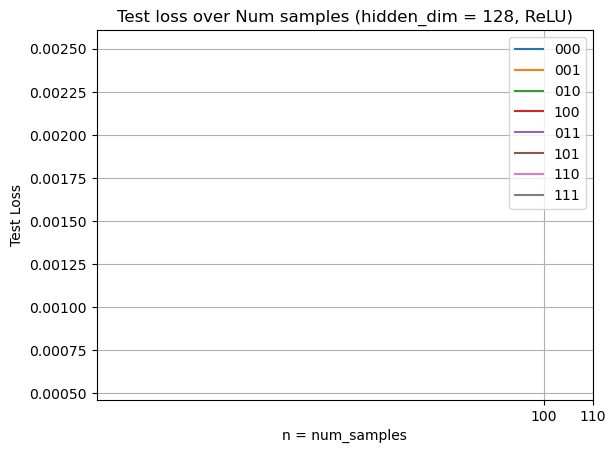

(1, 10, 160, 3)


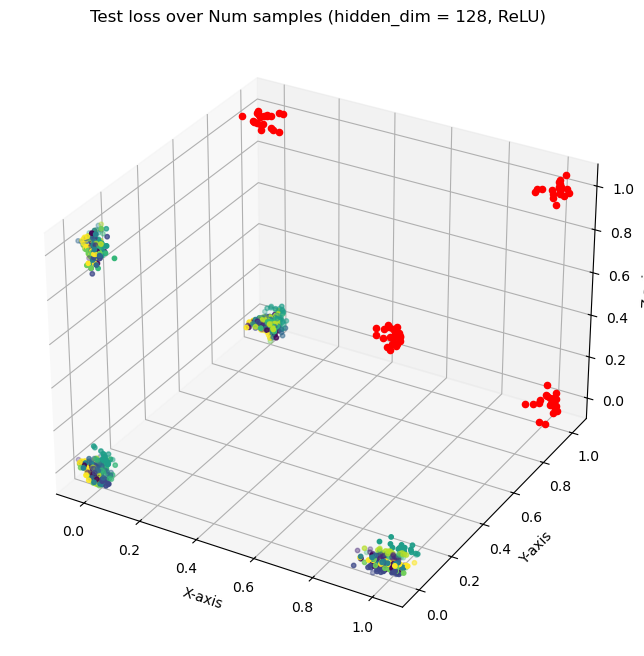

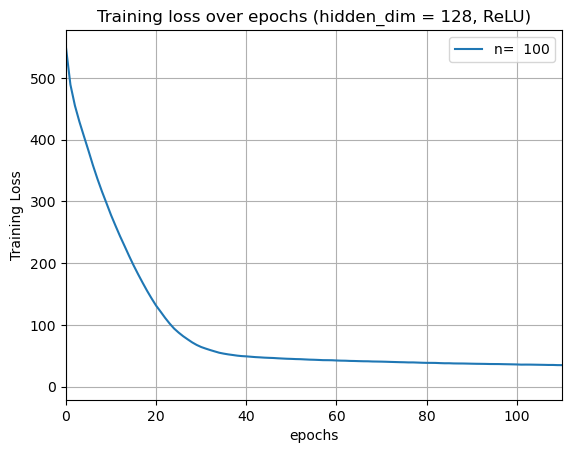

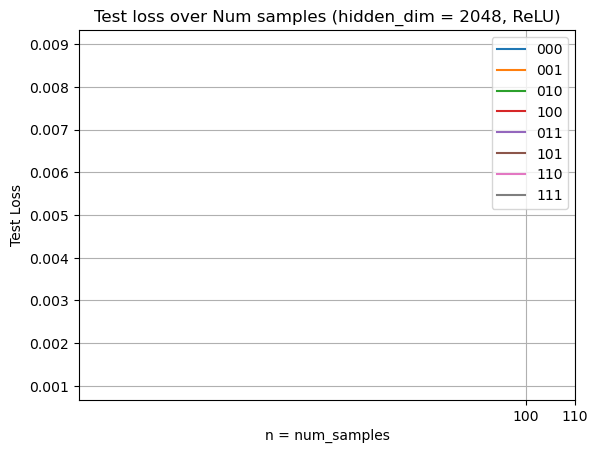

(1, 10, 160, 3)


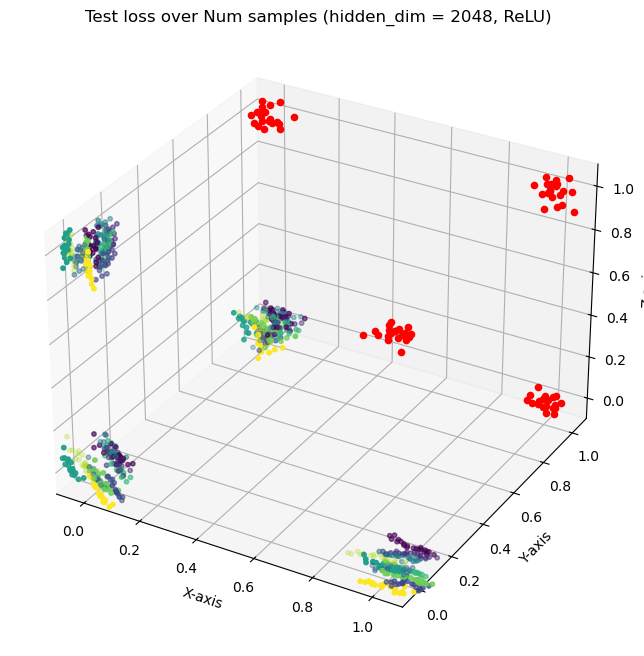

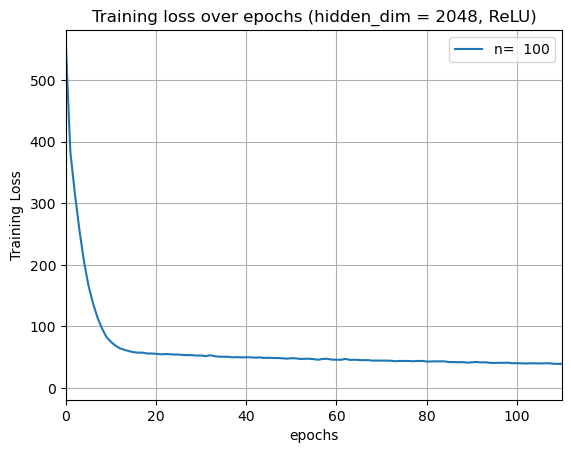

In [8]:
testLoss_list = [[] for _ in range(n_hiddDim)]

for i in range(n_hiddDim):
    hidden_dim = hidd_list[i]
    testLoss = compute_clusterLoss(eval_list[i], flippedIdentity(test_points_list[i]), test_centers, n_test)
    plot_clusterTestLoss(testLoss, test_centers, hidden_dim, activation_type, lo, hi, step, labels=10)
    testLoss_list[i] = np.reshape(testLoss, (8))
    
    scatter_testPredictions(eval_list[i],test_points_list[i], hidden_dim, test_ids=range(4, 8), n_test=n_test, activation_type = activation_type, k=k)
    
    plot_list = range(len(loss_n))
    plot_trainingLoss(losses_list[i], loss_n, plot_list, hidden_dim, activation_type, k, hi)
    

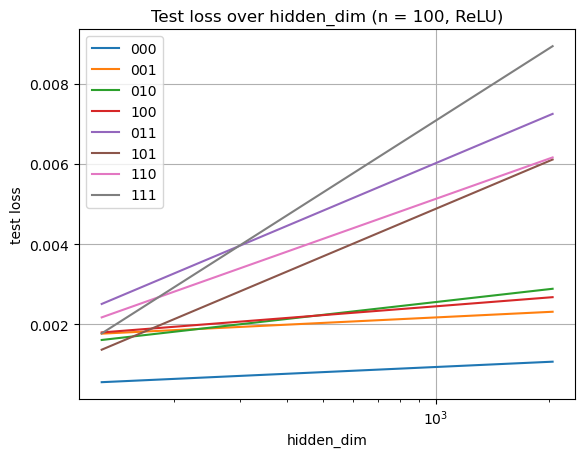

In [26]:
plot_hiddDim(np.array(testLoss_list), test_centers, hidd_list, lo=100)